# Approche non modale de la stabilité dans un écoulement de Poiseuille

## Table des matières

- Introduction et motivation
- Implémentation et test de la svd de $e^{Mt}$, calculée à partir des modes propres de $M$
    - Commençons par implémenter la svd pour un instant $t$ fixé 
    - Test de la svd sur un intervalle de temps
    - Soucis avec l'emploi de la matrice $M$
- Calcul détaillé de l'augmentation maximale pour un (Re,$\alpha$) donné
    - Efficacité de la stratégie de division récursive pour la recherche d'un maximum
- Implémentation et test de la svd de $e^{Mt}$, calculée avec Runge et Kutta
    - Implémentation du calcul de l'exponentielle
    - Test de la svd
- Implémentation sur gpu avec Runge et Kutta

## Introduction et motivation

Dans les notebooks précédents, nous avions étudié l'équation d'Orr-Sommerfeld que nous avions discrétisée et ramenée à un problème aux valeurs propres généralisé $A\hat v = Bc \hat v$ en considérant des modes propres de la forme $\hat v = v(y)\, e^{i\alpha (x-ct)}$.
 
Nous pouvons ramener ce problème aux valeurs propres à une équation d'évolution pour les modes propres. En effet, nous observons que

$$ \partial_t \hat v = -i\alpha c \hat v   \qquad   B^{-1}A \hat v = c \hat v $$

Et donc 

$$ \partial_t \hat v = M \hat v   \qquad M = -i\alpha B^{-1}A$$

Dans le notebook précédant, nous avions discuté de la stabilité de l'écoulement en observant la partie imaginaire des valeurs propres de l'opérateur $M$. Dans ce notebook, nous allons effectuer une analyse plus détaillée de l'évolution des perturbations. Nous nous limiterons plus à étudier le comportement des modes propres, car une telle analyse est incomplète étant donné la nature non linéaire des équations de Navier-Stokes. 

L'inconvénient de l'étude modale de la stabilité vient de la non orthogonalité des vecteurs propres de l'opérateur $M$. En effet, la matrice $M$ n'est pas hermitienne et il est donc possible que ces vecteurs propres soient non orthogonaux. Cela a pour conséquence qu'une combinaison linéaire de deux vecteurs propres, i.e. dont la norme diminue dans le temps, peut voir sa norme grandir avec le temps, pendant un temps fini. Le problème posé par cette croissance temporaire de certaines perturbations est que si celle-ci devient trop importante, l'approximation linéaire des équation de Navier-Stokes sur laquelle repose l'équation d'Orr-Sommerfeld n'est plus valable et la perturbation considérée, composée que de mode stables *selon l'équation d'Orr-Sommerfeld*, pourrait devenir instable.

Il est donc nécessaire de déterminer quelles sont les croissances maximales que l'on peut obtenir avec des combinaisons linéaires des modes stables afin de vérifier si celles-ci ne sont pas trop grandes pour engendrer des instablilités. Ce travail s'effectue typiquement par une décomposition en valeurs singulières (svd), qui va chercher l'élongaltion et la direction d'élongation maximale de la boule unité sous une transformation linéaire.

## Implémentation et test de la svd de $e^{Mt}$, calculée à partir des modes propres de $M$

### Commençons par implémenter la svd pour un instant $t$ fixé 

In [1]:
import numpy,scipy,scipy.linalg,time
import matplotlib.pyplot as pyplot
from matplotlib import rcParams, cm
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

Importons les fonctions que nous avons défini afin de construire les opérateurs nécessaires.

In [2]:
import operateurs

In [3]:
N = 401 
alpha = 0.6
Re = 10000
t = 1

[A,B] = operateurs.buildAB_forward(Re, alpha, N)

Calculons l'exponentielle $e^{Mt}$ à partir de la décomposition en valeurs et vecteurs propres de M.

In [4]:
def expMt_modes(A,B,alpha,t):

    [c,vecp] = scipy.linalg.eig(A,B)
    c = -1j*alpha*c # pour avoir les valeurs propres de M = -i*alpha*B^-1*A
    vecp_inv = numpy.linalg.inv(vecp)

    D = scipy.eye(N-4) * numpy.exp(c*t)
    return numpy.dot( numpy.dot( vecp , D) , vecp_inv )

In [5]:
start = time.time()

expMt = expMt_modes(A,B,alpha,t)

print(time.time()-start)
print(expMt[:2,:2])

1.4138829708099365
[[-0.04796193+0.00102805j  0.00146956+0.00067164j]
 [-0.10054344+0.00208506j -0.00372828+0.00150026j]]


Nous faisons ensuite le calcul de la svd

In [6]:
u,s,v = scipy.linalg.svd(expMt)
print(s[:5])

[ 5.27193368  3.1653444   1.18171657  1.14802061  1.06273988]


### Test de la svd sur un intervalle de temps

Nous implémentons le calcul de la svd pour plusieurs points de temps dans des fichiers séparés que nous importons ci-dessous.

In [7]:
import svd

In [8]:
N = 401
alpha = 0.6
Re = 10000
t_vec = numpy.linspace(0,100,50)

[A,B] = operateurs.buildAB_forward(Re, alpha, N)

start = time.time()
s = svd.svd_scipy_exp_eig_A_B(A, B, alpha, t_vec, False)
print("Temps d'exécution: {:.3f} secondes".format(time.time()-start))

# valeurs singulières max pour chaque t
print("Valeurs singulières: ")
print(s[:,1])

Il n'y a pas de modes instables ni stationnaires
Temps d'exécution: 7.238 secondes
Valeurs singulières: 
[  1.           3.06204846   3.58970773   4.59748173   5.91593205
   7.50431125   9.33743158  11.37950719  13.57949592  15.87226814
  18.18166593  20.42441655  22.51458311  24.36835428  25.90893431
  27.07123188  27.80600963  28.08316084  27.893827    27.25115486
  26.18960288  24.76283156  23.04033552  21.10308204  19.0384972
  16.93517243  14.8776352   12.941418    11.18845441   9.6625917
   8.38510057   7.35130253   6.53176912   5.88128281   5.35268489
   4.90783221   4.52135961   4.17883487   3.87270365   3.59844143
   3.35206822   3.12924341   2.92550293   2.73692525   2.56064159
   2.39493954   2.23900506   2.09249692   1.95515943   1.82660388]


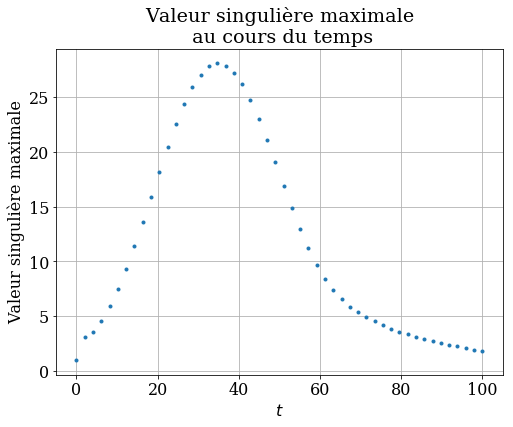

In [9]:
pyplot.figure(figsize=(8,6));
pyplot.plot(t_vec, s[:,1], '.');
pyplot.title('Valeur singulière maximale\n au cours du temps');
pyplot.xlabel('$t$');
pyplot.ylabel('Valeur singulière maximale');
pyplot.legend(loc=1);
pyplot.grid();
pyplot.show();

### Soucis avec l'emploi de la matrice $M$

Remarquons que nous avons effectué la décomposition en modes propres de $M$ à partir du problème généralisé défini par $A$ et $B$. Nous évitons de calculer l'exponentielle de $M$ à partir de sa décomposition directe car cette dernière n'est pas correctement réalisée par l'ordinateur, probablement à cause de l'inversion de la matrice $B$ qui comporte des nombres très petits. Les décompositions respectives avec $M$ d'une part et $A,B$ de l'autre sont réalisées ci-dessous.

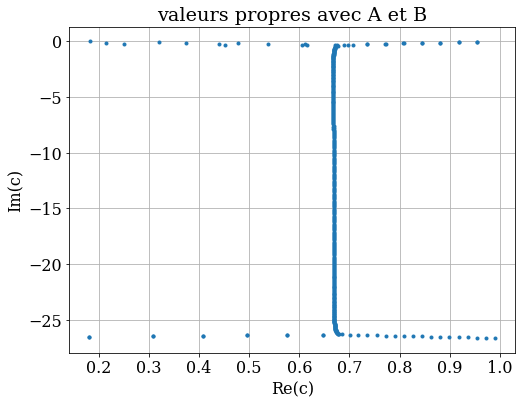

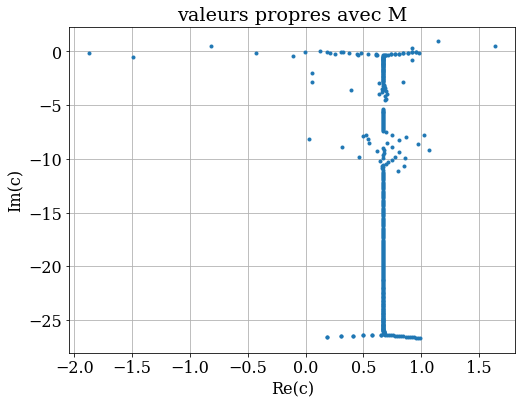

In [10]:
N = 401
alpha = 0.6
Re = 10000
t_vec = numpy.linspace(0,0.5,10)

[A,B] = operateurs.buildAB_forward(Re, alpha, N)
M = numpy.dot(numpy.linalg.inv(B), A) 

# Décomposition en valeur et vecteur propres avec A et B
[c,vecp] = scipy.linalg.eig(A,B)

pyplot.figure(figsize=(8,6));
pyplot.plot(numpy.real(c), numpy.imag(c), '.');
pyplot.title('valeurs propres avec A et B');
pyplot.xlabel('Re(c)');
pyplot.ylabel('Im(c)');
pyplot.legend(loc=1);
pyplot.grid();
pyplot.show();

# Décomposition en valeur et vecteur propres de M
[c,vecp] = scipy.linalg.eig(M)

pyplot.figure(figsize=(8,6));
pyplot.plot(numpy.real(c), numpy.imag(c), '.');
pyplot.title('valeurs propres avec M');
pyplot.xlabel('Re(c)');
pyplot.ylabel('Im(c)');
pyplot.legend(loc=1);
pyplot.grid();
pyplot.show();

## Calcul détaillé de l'augmentation maximale pour un (Re,$\alpha$) donné

Le problème auquel nous faisons face est la recherche du maximum de la fonction $f(t)$ que défini le calcul de plus grande valeur singulière de $e^{Mt}$ en chaque $t$.

Pour accélérer la recherche de ce maximum, nous allons exploiter la monotonie apparente de la fonction $f$ avant et après le maximum et employer la stratégie récursive suivante:
- Commencer avec un intervalle suspecté de contenir le maximum
- Diviser l'intervalle en plusieurs segments
- Evaluer $f$ en les jonctions entre ces segments
- Trouver le point de jonction $t_\star$ qui maximise $f$
- Prendre comme nouvel intervalle l'union des deux segments de part et d'autre de $t_\star$
- Recommencer jusqu'à atteintre la précision voulue

Cette méthode est implémentée dans un fichier que nous importons ci-dessous.

In [11]:
import svd_division_recursive as rd

In [12]:
N = 401
alpha = 0.6
Re = 10000
tmin = 0
tmax = 100
target_prec = 0.01

[A,B] = operateurs.buildAB_forward(Re, alpha, N)

start = time.time()
s_max,t_max,err_tmax = rd.svd_division_recursive_A_B(svd.svd_scipy_exp_eig_A_B, A, B, alpha, tmin, tmax, target_prec, 6)
print("Temps d'exécution: {:.3f} secondes".format(time.time()-start))

print("Résultats: ")
print("Valeur singulière maximale:",s_max)
print("Instant de perturbation maximale:",t_max, "+/-", err_tmax)

Il n'y a pas de modes instables ni stationnaires
Il n'y a pas de modes instables ni stationnaires
Il n'y a pas de modes instables ni stationnaires
Il n'y a pas de modes instables ni stationnaires
Il n'y a pas de modes instables ni stationnaires
Il n'y a pas de modes instables ni stationnaires
Il n'y a pas de modes instables ni stationnaires
Il n'y a pas de modes instables ni stationnaires
Il n'y a pas de modes instables ni stationnaires
Temps d'exécution: 14.550 secondes
Résultats: 
Valeur singulière maximale: 28.0851862381
Instant de perturbation maximale: 34.8828938678 +/- 0.00508052634253


La valeur trouvée semble bien correspondre à ce que nous avions obtenu précédemment.

### Efficacité de la stratégie de division récursive pour la recherche d'un maximum

Nous montrons ci-dessous l'efficacité de plusieurs stratégies de recherche de maximum en calculant la précision que nous pouvons atteindre en $N$ calculs de svd. Nous ne tenons pas en compte le calcul de l'exponentielle ou plutôt supposons que celui-ci requiert le même investissement en temps pour n'importe quel instant $t$. 

La précision considérée est la taille de l'intervalle contenant le maximum après $N$ calculs par rapport à sa taille initiale.

Les stratégies que nous testons sont les suivantes:
- Stratégie "force brute": Evaluation en pleins de points répartits uniformément dans l'intervalle initialement choisi. La précision diminue à peu près comme l'inverse de N
- Stratégie "division récursive", expliquée plus haut, que nous testons pour plusieurs nombres de segments.

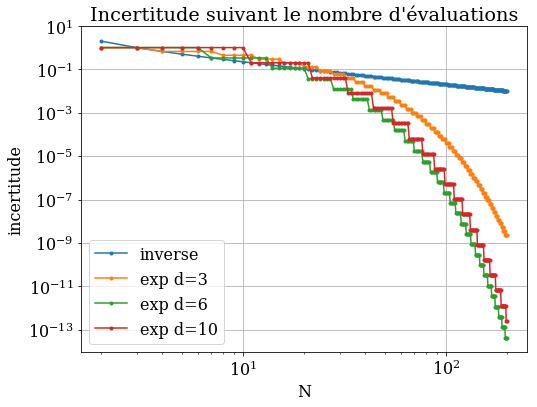

In [13]:
N = range(2,200)

def incertinv(N):
    return 2/(N-1)

def incertexp(N,d):
    it = int(N/(d+1))  # une itération est composée de d+1 évaluations de la fonction à maximiser
    return (2/d)**it

vinv = numpy.vectorize(incertinv)
vexp = numpy.vectorize(incertexp)

pyplot.figure(figsize=(8,6));
pyplot.loglog(N, vinv(N), '.-', label='inverse');
pyplot.loglog(N, vexp(N,3), '.-', label='exp d=3');
pyplot.loglog(N, vexp(N,6), '.-', label='exp d=6');
pyplot.loglog(N, vexp(N,10), '.-', label='exp d=10');
pyplot.title('Incertitude suivant le nombre d\'évaluations');
pyplot.xlabel('N');
pyplot.ylabel('incertitude');
pyplot.legend(loc=3);
pyplot.grid();
pyplot.show();

Nous constatons sans surprise que la stratégie récursive est la plus efficace, avec un maximum d'efficacité autour d'une division en 6 segments. C'est donc la stratégie que nous avons utilisé dès que nous en avons l'occasion.

## Implémentation et test de la svd de $e^{Mt}$, calculée avec Runge et Kutta

### Implémentation du calcul de l'exponentielle

L'inconvénient avec le calcul de $e^{Mt}$ à partir des valeurs et vecteurs propres de $M$ est que cette méthode est limitée au cas où $M$ est indépendante du temps. Si $M$ varie dans le temps, en particulier si le profil de vitesse $U(y,t)$ dépend du temps, alors la décomposition en modes propres de $M(t)$ est à refaire pour chaque instant $t$.

Heureusement, il existe une manière plus efficace de calculer l'exponentielle $e^{Mt}$ sans refaire systématiquement la décomposition en modes propres. Cette méthode consiste à intégrer avec l'algorithme de Runge et Kutta une équation différentielle dont $e^{Mt}$ est la solution. Il facile de construire une telle équation en remarquant que:

$$ \frac{d}{dt} e^{Mt} = M e^{Mt} $$

Nous voyons donc que $e^{Mt}$ est solution du problème de Cauchy suivant:

$$ \dot L(t) = M L(t) \qquad L(0) = \mathbb{1}$$

Nous réécrivons l'équation différentielle sous la forme

$$ \dot L(t) = f(t,L)  \qquad f(t,L) = M(t)L $$

Nous allons dans ce qui suit implémenter cette méthode et commencer par la tester avec le profil $U(y,t) = 1-y^2$ indépendant du temps pour pouvoir comparer les résultat avec la méthode utilisant les modes propres de $M$. L'intégrateur choisi sera Runge et Kutta d'ordre 4.

In [14]:
import operateurs_t

In [15]:
def U_statique(y,t):
    return 1-y**2

def f(t,L,Re,alpha,N):
    
    [A,B] = operateurs_t.buildAB_forward(Re, alpha, N, U_statique, t)
    B_inv = numpy.linalg.inv(B)
    M = -1j*alpha*numpy.dot(B_inv,A)
    
    return numpy.dot(M,L)

Nous commençons par calculer l'exponentielle $e^{Mt}$ en un temps $t$ donné.

In [16]:
N = 401
alpha = 0.6
Re = 10000
t_max = 10
dt = 0.1

nt = int(t_max/dt)+1

t = 0
L = scipy.eye(N-4)

for i in range(1,nt+1):
    
    # La matrice L=exp(Mt) est avancé de dt dans le temps avec RK4
    k1 = dt*f(t,L,Re,alpha,N)
    k2 = dt*f(t+dt/2,L+k1/2,Re,alpha,N)
    k3 = dt*f(t+dt/2,L+k2/2,Re,alpha,N)
    k4 = dt*f(t+dt,L+k3,Re,alpha,N)
    
    t = t+dt
    L = L + 1/6*(k1+2*k2+2*k3+k4)

Nous pouvons ensuite comparer le résultat avec celui donné par la méthode aux modes propres implémentée plus haut.

In [17]:
print(t)
print("L_RK4",L[:2,:2])

L_modes = expMt_modes(A,B,alpha,t)
print("L_modes",L_modes[:2,:2])

10.09999999999998
L [[-0.00294632+0.00141452j -0.00176832+0.00106436j]
 [-0.00656012+0.00306141j -0.00394453+0.00231681j]]
L_modes [[-0.00294632+0.00141452j -0.00176832+0.00106436j]
 [-0.00656012+0.00306141j -0.00394453+0.00231681j]]


Nous remarquons que nous pouvons obtenir des résultats très proches (indistinguables avec le nombre de décimales affiché par défaut) pour des $dt$ suffisamment petits. Typiquement $\leq 0.1$ dans notre example. Cependant, l'exponentielle calculée par RK4 diverge rapidement pour des pas de temps supérieur à une certaine valeur critique, située entre $0.1$ et $0.2$ dans notre cas. Il doit probablement y avoir une certaine condition de convergence que nous pourrions imposer au pas de temps $dt$.

### Test de la svd

Ci-dessous, nous réalisons la svd pour plusieurs temps en utilisant RK4. La méthode est implémentée dans le fichier "svd_t" que nous importons ci-dessous.

In [18]:
import svd_t

In [19]:
def U_statique(y,t):
    return 1-y**2

In [20]:
N = 401
alpha = 0.6
Re = 10000
t_max = 100
dt = 0.1
step = 20 # nous réalisons le calcul de la svd qu'une fois sur 20

start = time.time()
st,t_vec = svd_t.svd_scipy_RK4(Re,alpha,N,t_max,dt,step,U_statique)
print("Temps d'exécution: {:.3f} secondes".format(time.time()-start))

Temps d'exécution: 340.545 secondes


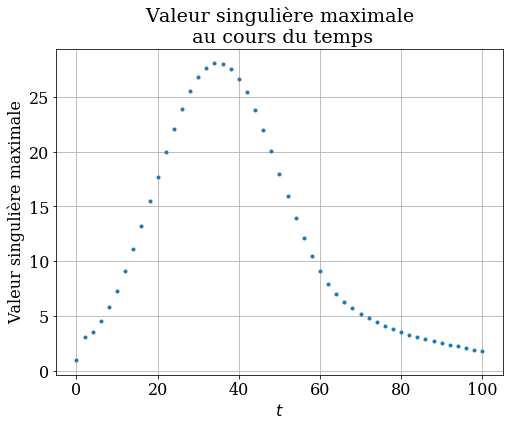

In [21]:
pyplot.figure(figsize=(8,6));
pyplot.plot(t_vec, st[:,1], '.');
pyplot.title('Valeur singulière maximale\n au cours du temps');
pyplot.xlabel('$t$');
pyplot.ylabel('Valeur singulière maximale');
pyplot.legend(loc=1);
pyplot.grid();
pyplot.show();

Nous vérifions que la courbe de la valeur singulière maximale avec le temps est cohérente avec celle utilisant la décomposition en modes propres.

## Implémentation sur gpu avec Runge et Kutta

Nous allons dans cette section utiliser le module "tensorflow" pour effectuer le calcul de l'exponentielle sur une carte graphique (gpu). L'implémentation des méthodes est réalisée dans le fichier que nous importons ci-dessous.

In [1]:
import svd_t_gpu

ModuleNotFoundError: No module named 'svd_t_gpu'

$$\ $$
$$\ $$
$$\ $$

*La cellule qui suit permet l'importation immédiate de tout les fichiers externes nécessaires pour ce notebook.*

In [22]:
import numpy,scipy,scipy.linalg,time
import matplotlib.pyplot as pyplot
from matplotlib import rcParams, cm
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

import operateurs
import operateurs_t
import svd
import svd_division_recursive as rd
import svd_t